### Notes / ToDos
* Make assumptions explicit (maybe in "Idea" section)
* Idea: Change "Idea" section to "Hypothesis" with focus on data + assumptions?
* Find a better way to include configuration of data collection (currently this bloats the notebook)
* Possible to reduce lines of code?
* Plot for throughupt per day needed? Reduce to simple df.head()? --> What is the value / conclusion? 
* Plot for distribution needed? Reduce to simple df.head()? --> What is the value / conclusion? Do I need this to understand the notebook?

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set(context='notebook', style='whitegrid', font='serif')
%matplotlib inline

# Monte Carlo Simulation "How Many"
## Context
At our planning on 28th January 2018 Jacob remarked that the planned scope of 7 work items is maybe too large for the next 14-day sprint. Before we make a commitment for this scope and delivery date, we have to forecast the probility of outcome.

## Idea

To understand the current delivery capability, we tracked our throughput and cycle times of our work items in the issue tracking tool [Jira](https://de.atlassian.com/software/jira). We can use this data to forecast future throughput. 

The measurement took place between 13th July 2018 and 30th January 2019. The results were exported into a CSV file using the [Jira-to-Analytics](https://github.com/ActionableAgile/jira-to-analytics) command line tool with the following configuration:
```
[...]
Criteria:
    Project: 
        - DATA
    Issue types: 
        - Story
        - Task
        - Bug
    Start Date: 2018-07-13
    End Date: 2019-01-30

Workflow:
[...]

```
The CSV file contains all work items that were created and moved through during the measurement’s time span. We just take the relevant data of completed work items: completion date and type

In [2]:
kanban_data = pd.read_csv('data.csv', usecols=['Done', 'Type'], parse_dates=['Done']).dropna()
kanban_data.head(2)

,Done,Type
0,2018-09-26,Story
1,2018-09-13,Story


## Analysis

Based on the past throughput per day a forecast can be created with a monte carlo simulation. The throughput is the total amount of completed work items per day.

### Calculate Throughput
Therefore, we sum up the completed work items per day and add the missing dates with zero throughput. We plot the data of the throughput per day to get a brief overview of the result.

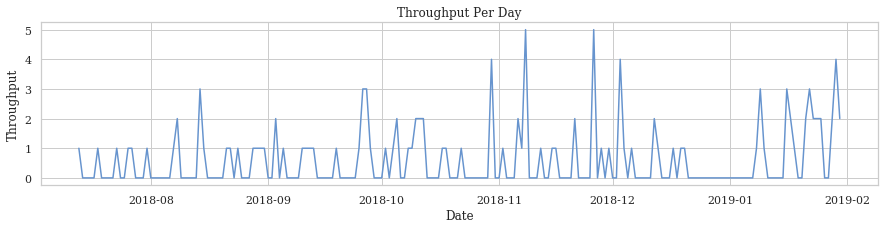

In [3]:
throughput = pd.crosstab(kanban_data.Done, kanban_data.Type, colnames=[None]).reset_index()
throughput['Throughput'] = throughput.Bug + throughput.Story + throughput.Task
date_range = pd.date_range(start=throughput.Done.min(), end=throughput.Done.max())
throughput = throughput.set_index('Done').reindex(date_range).fillna(0).astype(int).rename_axis('Date')
plt.figure(figsize=(15,3))
ax = sns.lineplot(x='Date', y='Throughput', data=throughput.reset_index(), color='#6794CE')
ax.set_title("Throughput Per Day");

### Run Monte Carlo Simulation 'How Many'
Based on the throughput data we simulate multiple times how many items can be completed in the given time span. Before we run the simulation we set the configuration values:
* We set the number of past days to select the data that we want to rely on. 
* We set the number of days to simulate. 
* We set the number of simulations to run (recommended 10000 times).

We plot the simulation results to get a brief overview of distribution of total items completed in the given timespan.

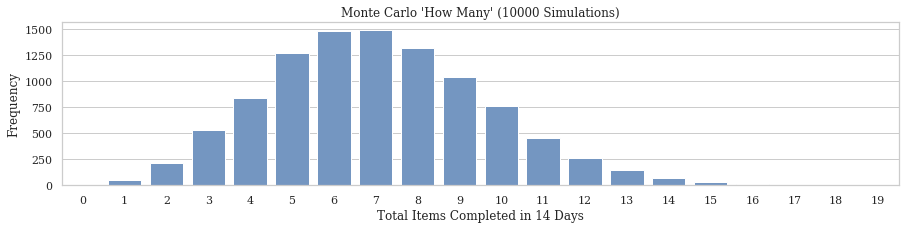

In [4]:
### SETTINGS ####
PAST_DAYS = 100
DAYS_TO_SIMULATE = 14
SIMULATIONS = 10000
###
dataset = throughput[['Throughput']][: PAST_DAYS].reset_index(drop=True)
samples = [dataset.sample(n=DAYS_TO_SIMULATE).sum().Throughput for i in range(SIMULATIONS)]
samples = pd.DataFrame(samples, columns=['Items'])
distribution = samples.groupby(['Items']).size().reset_index(name='Frequency')
plt.figure(figsize=(15,3))
ax = sns.barplot(x = 'Items', y = 'Frequency', data=distribution, color='#6794CE')
ax.set_title("Monte Carlo 'How Many' (%d Simulations)" % SIMULATIONS)
ax.set(xlabel='Total Items Completed in %d Days' % DAYS_TO_SIMULATE);

### Analysis of the Probabilities of Occurrence
We determine the probability for each number of completed items by cumulating the frequency in the simulations. We plot the probability for each number of completed items and indicate the percentiles 70%, 85%, and 95%.

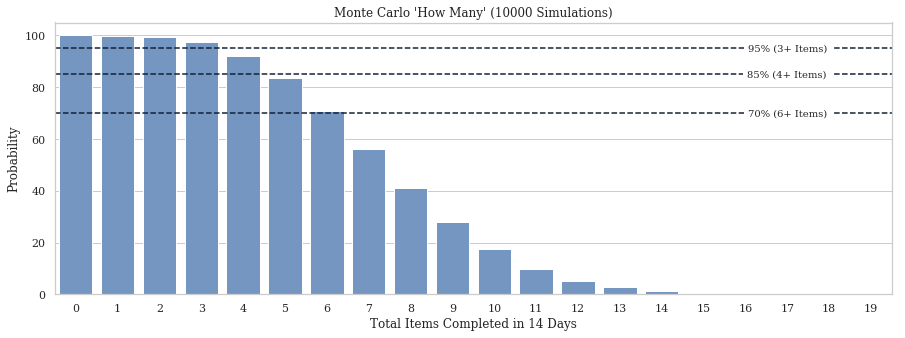

In [5]:
distribution = distribution.sort_index(ascending=False)
distribution['Probability'] = 100*distribution.Frequency.cumsum()/distribution.Frequency.sum()
plt.figure(figsize=(15,5))
ax = sns.barplot(x='Items', y='Probability', data=distribution, color='#6794CE')
ax.set_title("Monte Carlo 'How Many' (%d Simulations)" % SIMULATIONS)
ax.set(xlabel='Total Items Completed in %d Days' % DAYS_TO_SIMULATE);
ax.axhline(70, color="#102035", linestyle='--')
ax.axhline(85, color="#102035", linestyle='--')
ax.axhline(95, color="#102035", linestyle='--')
label_xpos = distribution['Items'].max()-2
ax.text(y=70, x=label_xpos, s='70%% (%d+ Items)' % samples.Items.quantile(0.3), va='center', ha='center', backgroundcolor='w')
ax.text(y=85, x=label_xpos, s='85%% (%d+ Items)' % samples.Items.quantile(0.15), va='center', ha='center', backgroundcolor='w')
ax.text(y=95, x=label_xpos, s='95%% (%d+ Items)' % samples.Items.quantile(0.05), va='center', ha='center', backgroundcolor='w');

## Conclusion
With a 60% probability of occurence a scope of 7 items in 14 days is risky and the scope should be reduced to at least 5-6 items to meet the 70% percentile.